# The reproducing kernel particle method.

In [1]:
from popcorn import *
from popcorn.functional import *
init_printing()

This notebook generates a kernel for the heat equation using the reproducing kernel partical method.
The hyperedge looks like a cloud of points $x$ in the support $H(y)$ around an EvalPt $y$, with the following order of the edge:
```
   x1         x2
           x3
     x4
  x5   (y0)  x7
    x8         x6

          v-- DOFs in H(y) are packed in the back
  [ y0 ] [ x1 x2 .... xl_edge ]
   ^-- Eval pt is first Vertex
```
The hyperedge has a variable length. The first vertex is the Eval node (0 to 1), and the remaining are DOF Pts, (1 to l\_edge). Vertex -1 denotes a global variable.

In [2]:
gdim=2
II, JJ, l_edge = symbols('II JJ l_edge')
Npt = l_edge - 1
EvalVec = DofSpace(gdim, 0,1)
EvalSca = DofSpace(1, 0,1)
PtVec = DofSpace(gdim, 1,l_edge)
PtSca = DofSpace(1, 1,l_edge)
Param = DofSpace(1, -1)

Theres are our inputs: $y$ is the location of the evaluation point, $sup$ and $w$ are the support radius and gauss weight associated with that point. Then, $x$ and $u$ are the point of the DOF node and the value of the scalar field coefficient at that node. For these class of methods, note that $u(x_I)\neq u_I$!

In [3]:
i_y = Input('y', EvalVec)
i_sup = Input('sup', EvalSca)
i_w = Input('w',EvalSca)
i_x = Input('x', PtVec)
i_u = Input('u', PtSca)
i_params = Input('params', Param)
i_lambda = Input('lambda',EvalSca)
i_ubar   = Input('ubar',EvalSca)

Since `i_u` is a variable length input, we can't manipulate it directly, need to get the degrees of freedom with a symbolic array reference:

In [4]:
uI = i_u.Vertex_Handle(II)
uI

## The function approximation

Now lets make our RKPM object using the helper functions written in
[rkpm_lib.py](rkpm_lib.py). It needs to take in the inputs to the hypervertex description for the nodes and eval point, a symbol or fixed number for the support radius, and then the hyperparameter choice.

These methods have three **hyperparameters**:
1. The polynomial basis functions: $P_i(\mathbf{x})$
2. The radial basis function: $W(r)$
3. How to compute the gradients

Let's make one instance and walk through the components to describe the math that's going on in RKPM_Basis.

In [5]:
from rkpm_lib import *
RKPM = RKPM_Basis(i_x,i_y.as_matrix(),i_sup[0], Polys[1],Weights['const'])

Let $\mathbf{r}_I = \mathbf{x}_I-\mathbf{y}$.
The method first builds up the moment matrix of the radial basis function and the polynomial basis,
\begin{equation}
M_{ij}(y) = \sum_{I=1}^{N} W\left(\frac{\left|\mathbf{r}_I\right|}{S}\right) P_i(\mathbf{r}_I) \otimes P_j(\mathbf{r}_I)
\end{equation}

(3, 3)


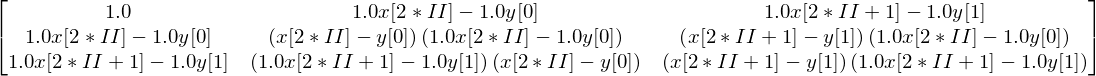

In [6]:
print RKPM.M_expr.shape
RKPM.M_expr

At every point $y$, the moving least squares type of discretization computes the coefficients to the polynomial basis by inverting the mass matrix
\begin{equation}
\{\mathbf{c}(y)\} = [\mathbf{M}(y)]^{-1} \{\mathbf{P}(0)\}
\end{equation}
This can't be done analytically in the general case, so our RKPM library inserts calls to the GNU Scientific Library as injected C code in the Popcorn AST. The kernel first computes the moment matrix around $y$ and takes the LU decomposition of it. We'll be computing multiple $c(y)$.

The final shape function for a node in the support is given by
\begin{equation}
N_I(y) = W\left(\frac{\left|\mathbf{r}_I\right|}{S}\right) \sum_{i=1}^{poly} c_i(\mathbf{r}_I) P_i(\mathbf{r}_I)
\end{equation}

In [7]:
RKPM.NJ

Even to get the value at the nodes, we need to perform the basis function interpolation: 
\begin{equation}
u(y) = \sum_{I=1}^{N} N_{I}(y) u_I
\end{equation}

In [8]:
# Evaluate u interpolation
o_uy = Output('uy', [EvalSca],1)
Kernel("interp_u",
        listing = RKPM.init_prgm + [
        Loop(II,0,Npt,[
            Asgn(o_uy, RKPM.NI * uI, '+=')
        ]),
        ] + RKPM.close_prgm
      )

<popcorn.Kernel.Kernel instance at 0x7f50cf456878>

## Solving a variational form

Now define some field $u$ with a test $\delta u$. The functional we are solving is a weak form equation
\begin{equation}
0= \int_\Omega \nabla \delta u \cdot \nabla u + \delta u f \,\mathrm{d}x \quad \forall \delta u
\end{equation}
We create two popcorn field objects and use them to symbolically create the potential density $P$:

In [9]:
# Scalar solution and a test
u = Field("u",gdim,0)
tu = Field("tu",gdim,0)
# Make the funtional
P = inner(grad(tu),grad(u)) + tu[0]*1
# Annoying matrix behavior for the scalar tu[0]
print P

field_tu[0] + grad_field_tu[0]*grad_field_u[0] + grad_field_tu[1]*grad_field_u[1]


To minimize this potential and then linearize it, we need to compute the load vector and the tangent matrix for the discrete unknowns. The system contributions for each coefficient is obtained by taking the Gateaux derivatives against the shape functions,
\begin{equation}
R_I = \frac{\partial P}{\partial \delta u}\frac{\partial \delta u}{\partial a_I} + 
    \frac{\partial P}{\partial \nabla\delta u}\cdot\frac{\partial \nabla\delta u}{\partial a_I} \\
    = \frac{\partial P}{\partial \delta u} N_I + 
    \frac{\partial P}{\partial \nabla\delta u}\cdot\nabla N_I
\end{equation}
and
\begin{equation}
K_{IJ} = \frac{\partial R_I}{\partial u}\frac{\partial u}{\partial u_J} + 
    \frac{\partial R_I}{\partial \nabla u}\cdot\frac{\partial \nabla u}{\partial u_J}
\end{equation}

In [15]:
R = gateaux(P, tu,   Matrix([RKPM.NI]),RKPM.grad_NI)
R.simplify()
K = gateaux(R,  u,   Matrix([RKPM.NJ]),RKPM.grad_NJ)

In [18]:
o_R = Output('R', [PtSca], 1)
o_K = Output('K', [PtSca], 2)
Kernel("poisson_0",
    listing = RKPM.init_prgm + [
        u,
        grad(u),
        Loop(II,0,Npt,[
            Asgn(u,      RKPM.NI * uI, '+='),
            Asgn(grad(u), RKPM.grad_NI * uI, '+=')
        ]),
        Loop(II,0,Npt,[
            Asgn(o_R.View((II,)), Matrix([i_w[0]*R]),"+="),
            Loop(JJ,0,Npt,[
                Asgn(o_K.View((II,JJ)), Matrix([i_w[0]*K]),"+=")
                ])
            ]),
    ] + RKPM.close_prgm
    )

<popcorn.Kernel.Kernel instance at 0x7f50cf384638>

In [19]:
#MyMat('poo',l_edge,l_edge, o_K.View((II,JJ)).offset)

Finally, we write all of them out to a husk

In [20]:
Husk('rkpm')

In [23]:
%%bash
ls husk_rkpm
cut -c -60 husk_rkpm/interp_u.c

CMakeLists.txt
__init__.py
interp_u.c
interp_u.h
kernels_rkpm.h
poisson_0.c
poisson_0.h
rkpm_swig.i
#include "interp_u.h"

#include "math.h"
#include <gsl/gsl_linalg.h>

void interp_u_eval(int l_edge,
/*Inputs:*/
const real_t * restrict u,
const real_t * restrict y,
const real_t * restrict x,
/*Outputs:*/
real_t * restrict uy)
{
real_t rkpm_M[9];{int i; for(i= 0;i<9;i++) rkpm_M[i]=0.0;}

{
int II;
for(II=(int)(0);II<(int)(l_edge - 1);II++) {
/* Evaluation of rkpm_M */
rkpm_M[0]+= 1.0;
rkpm_M[1]+= 1.0*x[2*II] - 1.0*y[0];
rkpm_M[2]+= 1.0*x[2*II + 1] - 1.0*y[1];
rkpm_M[3]+= 1.0*x[2*II] - 1.0*y[0];
rkpm_M[4]+= (x[2*II] - y[0])*(1.0*x[2*II] - 1.0*y[0]);
rkpm_M[5]+= (x[2*II + 1] - y[1])*(1.0*x[2*II] - 1.0*y[0]);
rkpm_M[6]+= 1.0*x[2*II + 1] - 1.0*y[1];
rkpm_M[7]+= (1.0*x[2*II + 1] - 1.0*y[1])*(x[2*II] - y[0]);
rkpm_M[8]+= (x[2*II + 1] - y[1])*(1.0*x[2*II + 1] - 1.0*y[1]
}
}


        
        gsl_matrix_view gsl_mat_rkpm_M 
          = gsl_matrix_view_array( rkpm_M, 3, 3 );
        gsl_permut